In [1]:
import pandas as pd

sen_df: pd.DataFrame = pd.read_csv('/media/ponbac/BigHDD/ethereum/blacklist/seniority/seniority-tornado-result.csv', index_col=0)

In [2]:
from typing import Optional
import numpy as np

from tqdm import tqdm
from pprint import pprint
from db.mongo.database import IndagoSession
from db.mongo.schemas import DARAddressMapping, DARGraph

# MONGO
db = IndagoSession
dar_collection = db['dar']
dar_map_collection = db['dar_map']


def filter_exchange_nodes(nodes, edges) -> list[str]:
    '''
    Calculates non-exchange nodes from graph data.
    '''
    non_exchange_nodes = []
    for edge in edges:
        # print(edge)
        non_exchange_nodes.append(nodes[edge[0]])

    return set(non_exchange_nodes)


async def process_graphs(batch_size: int = 10000, max_graphs: Optional[int] = None):
    '''
    Prints a bunch of statistics about the number of nodes in the DAR graphs.

    returns: numpy.array with the number of nodes in each graph
    '''
    n_graphs = await dar_collection.count_documents({})
    print(f'INFO: {n_graphs:,} DAR graphs in collection')
    if max_graphs is None:
        max_graphs = n_graphs

    node_counts = []
    graphs_with_seniority = []
    total_nodes_in_seniority = 0

    i = 0
    print(
        f'INFO: Fetching {max_graphs:,} graphs, batch_size={batch_size:,}...')
    pbar = tqdm(total=max_graphs)
    while i * batch_size < max_graphs + batch_size:
        cursor = dar_collection.find()
        cursor.skip(i * batch_size)
        for graph in await cursor.to_list(length=batch_size):
            n_nodes = len(graph['nodes'])
            node_counts.append(n_nodes)

            nodes_in_seniority = 0
            for address in filter_exchange_nodes(graph['nodes'], graph['edges']):
                try:
                    row = sen_df.loc[address]
                    #print(f'{row}')
                    if row['taint'] > 0:
                        nodes_in_seniority += 1
                        if nodes_in_seniority == 1:
                            graphs_with_seniority.append(graph)
                    del row
                except KeyError:
                    pass
            total_nodes_in_seniority += nodes_in_seniority

        pbar.update(batch_size)
        i += 1
    pbar.close()

    print(f'DONE: {sum(node_counts):,} total nodes (addresses)')
    print(f'STATS: average={(np.mean(node_counts)):.2f} nodes')
    print(f'STATS: median={(np.median(node_counts)):.2f} nodes')
    print(f'STATS: min={(np.min(node_counts))}')
    print(f'STATS: max={(np.max(node_counts)):,}')
    print(f'STATS: standard deviation={(np.std(node_counts)):.2f}')
    print(f'STATS: variance={(np.var(node_counts)):.2f}')
    print('\n---SENIORITY (TORNADO)---')
    print(
        f'STATS: nodes cross found={total_nodes_in_seniority:,}, percentage of total={(total_nodes_in_seniority / sum(node_counts) * 100):.2f}%')
    print(
        f'STATS: graphs with >0 nodes in seniority={len(graphs_with_seniority):,}, percentage of total={(len(graphs_with_seniority) / n_graphs * 100):.2f}%')

    return np.array(node_counts), graphs_with_seniority

node_counts, sen_graphs = await process_graphs(batch_size=50000, max_graphs=None)
# del sen_df

INFO: 965,652 DAR graphs in collection
INFO: Fetching 965,652 graphs, batch_size=50,000...


1050000it [01:59, 8819.00it/s]                           


DONE: 5,361,931 total nodes (addresses)
STATS: average=5.55 nodes
STATS: median=4.00 nodes
STATS: min=3
STATS: max=27,420
STATS: standard deviation=39.00
STATS: variance=1521.16

---SENIORITY (TORNADO)---
STATS: nodes cross found=342,981, percentage of total=6.40%
STATS: graphs with >0 nodes in seniority=238,536, percentage of total=24.70%


(5,)
0-10           892280
10-100          72770
100-1000          583
1000-10000         15
10000-30000         4
dtype: int64
INFO: one graphs: 731461, amount of addresses: 2577215
INFO: two graphs: 126020, amount of addresses: 849306
INFO: three graphs: 46183, amount of addresses: 453273
INFO: four graphs: 21867, amount of addresses: 281074
INFO: five graphs: 12292, amount of addresses: 195065
INFO: six graphs: 7583, amount of addresses: 143226
INFO: seven graphs: 19644, amount of addresses: 654007
INFO: eight graphs: 583, amount of addresses: 107313
INFO: nine graphs: 19, amount of addresses: 101452
                  label        sum
0      3 - 5\n(731,461)  48.065053
1      6 - 8\n(126,020)  15.839555
2      9 - 11\n(46,183)   8.453540
3     12 - 14\n(21,867)   5.242029
4     15 - 17\n(12,292)   3.637962
5      18 - 20\n(7,583)   2.671165
6    21 - 100\n(19,644)  12.197229
7    101 - 1,000\n(583)   2.001387
8  1,001 - 27,420\n(19)   1.892080


Text(0.5, 1.0, 'Share of addresses per cluster size')

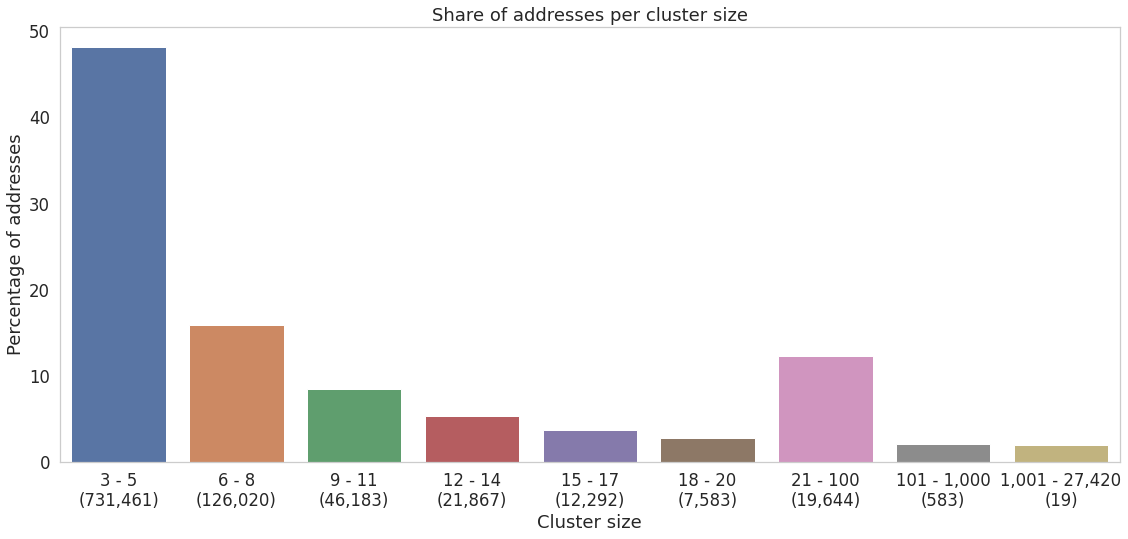

In [14]:
import seaborn as sns
import pandas as pd
import numpy as np

def reject_outliers(data, n_deviations=0.3):
    mean = np.mean(data)
    standard_deviation = np.std(data)
    distance_from_mean = abs(data - mean)
    not_outlier = distance_from_mean < n_deviations * standard_deviation
    return data[not_outlier]

node_count_ranges = [0, 10, 100, 1000, 10000, 30000]
node_count_labels = ['0-10', '10-100', '100-1000', '1000-10000', '10000-30000']
node_count_bins = pd.cut(node_counts, node_count_ranges, labels=node_count_labels)
sum_of_counts_per_bin = node_count_bins.value_counts().sort_index()
print (node_count_bins.value_counts().shape)
node_count_bins_values = node_count_bins.value_counts()
print(node_count_bins_values)

one_graphs = node_counts[node_counts <= 5]
two_graphs = node_counts[(node_counts > 5) & (node_counts <= 8)]
three_graphs = node_counts[(node_counts > 8) & (node_counts <= 11)]
four_graphs = node_counts[(node_counts > 11) & (node_counts <= 14)]
five_graphs = node_counts[(node_counts > 14) & (node_counts <= 17)]
six_graphs = node_counts[(node_counts > 17) & (node_counts <= 20)]
seven_graphs = node_counts[(node_counts > 20) & (node_counts <= 100)]
eight_graphs = node_counts[(node_counts > 100) & (node_counts <= 1000)]
nine_graphs = node_counts[(node_counts > 1000)]

print(f'INFO: one graphs: {len(one_graphs)}, amount of addresses: {sum(one_graphs)}')
print(f'INFO: two graphs: {len(two_graphs)}, amount of addresses: {sum(two_graphs)}')
print(f'INFO: three graphs: {len(three_graphs)}, amount of addresses: {sum(three_graphs)}')
print(f'INFO: four graphs: {len(four_graphs)}, amount of addresses: {sum(four_graphs)}')
print(f'INFO: five graphs: {len(five_graphs)}, amount of addresses: {sum(five_graphs)}')
print(f'INFO: six graphs: {len(six_graphs)}, amount of addresses: {sum(six_graphs)}')
print(f'INFO: seven graphs: {len(seven_graphs)}, amount of addresses: {sum(seven_graphs)}')
print(f'INFO: eight graphs: {len(eight_graphs)}, amount of addresses: {sum(eight_graphs)}')
print(f'INFO: nine graphs: {len(nine_graphs)}, amount of addresses: {sum(nine_graphs)}')

count_sum_df = pd.DataFrame({
    'label': [f'3 - 5\n({len(one_graphs):,})', f'6 - 8\n({len(two_graphs):,})', f'9 - 11\n({len(three_graphs):,})', f'12 - 14\n({len(four_graphs):,})', f'15 - 17\n({len(five_graphs):,})', f'18 - 20\n({len(six_graphs):,})', f'21 - 100\n({len(seven_graphs):,})', f'101 - 1,000\n({len(eight_graphs):,})', f'1,001 - 27,420\n({len(nine_graphs):,})'],
    'sum': [sum(one_graphs) / sum(node_counts) * 100, sum(two_graphs) / sum(node_counts) * 100, sum(three_graphs) / sum(node_counts) * 100, sum(four_graphs) / sum(node_counts) * 100, sum(five_graphs) / sum(node_counts) * 100, sum(six_graphs) / sum(node_counts) * 100, sum(seven_graphs) / sum(node_counts) * 100, sum(eight_graphs) / sum(node_counts) * 100, sum(nine_graphs) / sum(node_counts) * 100]
})
print(count_sum_df)

sns.set(style="whitegrid")
sns.set(rc = {'figure.figsize':(19,8)})
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'axes.grid' : False})

ax = sns.barplot(x="label", y="sum", data=count_sum_df)
ax.set(xlabel='Cluster size', ylabel='Percentage of addresses')
ax.set_title('Share of addresses per cluster size')

# ax = sns.countplot(x=node_count_bins, order=node_count_labels)
# ax.set(xlabel='Number of nodes in DAR graph', ylabel='Number of DAR graphs')
# ax.set_title('Number of nodes in DAR graphs')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# sns.set_style("whitegrid")
# sns.set(rc = {'figure.figsize':(15,8)})
# # p = sns.histplot(data=reject_outliers(node_counts), stat='percent', shrink=8.25)
# p = sns.histplot(data=node_count_bins.value_counts(), stat='percent', shrink=8.25)
# p.set_xlabel('Number of nodes/addresses in cluster', fontsize=16)
# p.set_ylabel('Percentage of graphs', fontsize=16)
# p.set_title('Distribution of number of nodes in DAR graphs', fontsize=16)


Text(0.5, 1.0, 'Distribution of number of nodes in graphs with >0 flagged nodes')

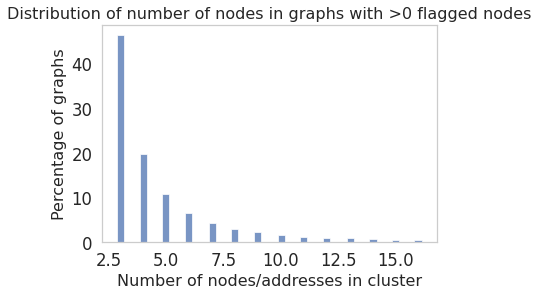

In [4]:
sen_node_counts = np.array([len(graph['nodes']) for graph in sen_graphs])

p = sns.histplot(data=reject_outliers(sen_node_counts), stat='percent', shrink=4.75)
p.set_xlabel('Number of nodes/addresses in cluster', fontsize=16)
p.set_ylabel('Percentage of graphs', fontsize=16)
p.set_title('Distribution of number of nodes in graphs with >0 flagged nodes', fontsize=16)

In [5]:
flagged_counts = []
total_counts = []
for graph in tqdm(sen_graphs):
    flagged = 0
    total = 0
    for address in filter_exchange_nodes(graph['nodes'], graph['edges']):
        total += 1
        try:
            row = sen_df.loc[address]
            flagged += 1
            del row
        except KeyError:
            pass
    flagged_counts.append(flagged)
    total_counts.append(total)

avg_flagged = np.mean(flagged_counts)
avg_total = np.mean(total_counts)

print(f'STATS: average flagged user nodes={avg_flagged:.2f} nodes')
print(f'STATS: average total user nodes={avg_total:.2f} nodes')
print(f'STATS: num clusters with a single flagged node={flagged_counts.count(1):,}')

100%|██████████| 238536/238536 [00:18<00:00, 12995.28it/s]

STATS: average flagged user nodes=1.44 nodes
STATS: average total user nodes=2.74 nodes
STATS: num clusters with a single flagged node=180,645


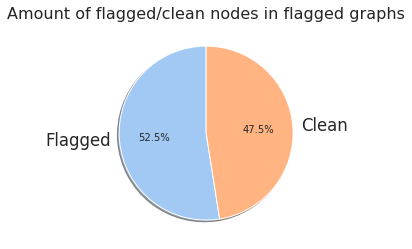

In [6]:
import matplotlib.pyplot as plt

data = [sum(flagged_counts), sum(total_counts) - sum(flagged_counts)]
labels = ['Flagged', 'Clean']
colors = sns.color_palette('pastel')[0:5]

plt.pie(data, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Amount of flagged/clean nodes in flagged graphs', fontsize=16)
plt.show()

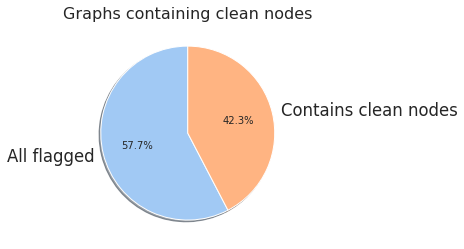

In [7]:
n_unflagged = []
for i, n in enumerate(flagged_counts):
    n_unflagged.append(total_counts[i] - n)
clusters_with_clean = list(filter(lambda x: x > 0, n_unflagged))

data = [len(flagged_counts) - len(clusters_with_clean), len(clusters_with_clean)]
labels = ['All flagged', 'Contains clean nodes']
colors = sns.color_palette('pastel')[0:5]

plt.pie(data, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Graphs containing clean nodes', fontsize=16)
plt.show()

In [8]:
# sum of n_unflagged
print(f'STATS: sum of clean nodes={sum(n_unflagged):,}')
# sum of flagged_counts
print(f'STATS: sum of flagged nodes={sum(flagged_counts):,}')

STATS: sum of clean nodes=310,491
STATS: sum of flagged nodes=342,981


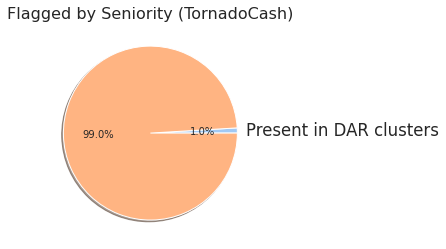

In [18]:
# Seaborn Pie Chart
# Total blacklisted: 36,025,207
# Flagged in DAR graphs: sum(flagged_counts)
data = [sum(flagged_counts), 36025207 - sum(flagged_counts)]
labels = ['Present in DAR clusters', '']
colors = sns.color_palette('pastel')[0:5]

plt.pie(data, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=0)
plt.title('Flagged by Seniority (TornadoCash)', fontsize=16)
plt.show()

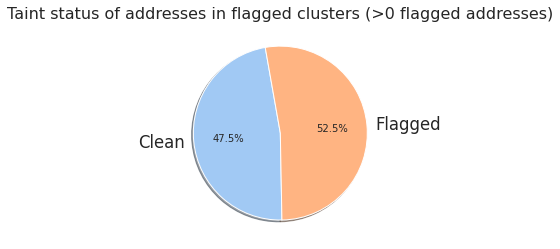

In [29]:
# Seaborn Pie Chart
# Clean nodes in flagged clusters.
data = [sum(n_unflagged), sum(flagged_counts)]
labels = ['Clean', 'Flagged']
colors = sns.color_palette('pastel')[0:5]

plt.pie(data, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=100)
plt.title('Taint status of addresses in flagged clusters (>0 flagged addresses)', fontsize=16)
plt.show()

In [9]:

# Free up memory
del sen_df